# Bilinear system identification with one output

This version was developed for the DOE proposal. Main advantage is that it does not assume that the system starts from the null initial state

## *Note this code is outdated see `bi_sys_id_my_version_demo.ipynb` instead !!!*

In [1]:
import numpy as np
from scipy.integrate import odeint
from itertools import repeat
import matplotlib.pyplot as plt
from scipy.linalg import logm, hankel, svd, lstsq

In [2]:
# Magnitudes of the controls
v = 2.5
# time step for measurements
dt = 1

In [3]:
def response(*, Ac, Nc, C, x0):
    
    def rhs_eq(x, t, E):
        """
        the rhs of the equation of motion
        """
        return (Ac + Nc * E) @ x
    
    time = dt * np.arange(20)
        
    # save response when only E is on
    responce = []
        
    for n in range(2, 7):
        # response when only u1 is on
        x_on = odeint(rhs_eq, x0, time[:n], args=(v,))
        x_off = odeint(rhs_eq, x_on[-1], time[(n-1):], args=(0.,))[1:]
        
        responce.append(
            np.vstack([x_on, x_off]) @ C
        )
            
    return np.array(responce)

In [4]:
# Matricies from the example in paper
Ac = np.array([[-1.2, 0], [1.1, -2]])
Nc = np.array([[0.1, 0.01], [1, 1]])
C = np.array([1, 1])
x0 = np.random.rand(2)

In [5]:
orig_responces = response(Ac=Ac, Nc=Nc, C=C, x0=x0)

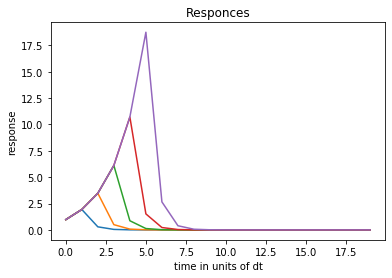

In [6]:
plt.title("Responces")
plt.plot(orig_responces.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

# System identification

## identify $C$ and $A_c$

In [7]:
Y1 = orig_responces[0]

In [8]:
# The shape of the hankel matrix 
alpha = 5

In [9]:
U1, Sigma1, V1_T = svd(hankel(Y1[1:(alpha + 1)], Y1[alpha:]), full_matrices=False)

In [10]:
Sigma1

array([1.98251767e+00, 5.38561584e-03, 1.01880280e-08, 8.24378786e-09,
       5.11077711e-09])

In [11]:
# we see that the rank of the system is 2
rank = 2

In [12]:
# declare parameters
m = 1 # number of outputs 
r = 1 # number of controls
p = 5 # number of measurments

In [13]:
C_reconstructed = U1[:m, :rank]

In [14]:
U1_up = U1[:-m,]
U1_down = U1[m:,]

In [15]:
Ac_reconstructed = logm(
    lstsq(U1_up, U1_down)[0][:rank, :rank] 
) / dt

In [16]:
# Calculate B1_bar as save it into the B_bar list
B_bar = [
    (Sigma1[..., None] * V1_T)[:rank, :r]
]

In [17]:
# truncate the rank of matrix
U1 = U1[:, :rank]

In [18]:
print("Is U1 left unitary?")
np.allclose(U1.conj().T @ U1, np.eye(rank))
# this is very important for calculating B2_bar, B3_bar etc

Is U1 left unitary?


True

## Identify $N_{ci}$ and the initial condition $x(0)$

In [19]:
B_bar.extend(
    U1.conj().T @ orig_responces[k - 1, k:(k + alpha)][..., None] for k in range(2, p + 1)
)

In [20]:
B_bar

[array([[-1.95958500e+00],
        [ 7.86733856e-04]]),
 array([[-3.51046505],
        [ 0.02898633]]),
 array([[-6.17290615],
        [ 0.06078595]]),
 array([[-10.81338484],
        [  0.11004097]]),
 array([[-18.92738755],
        [  0.19390753]])]

In [21]:
C = [c.reshape(p, rank).T for c in np.hsplit(np.vstack(B_bar), 1)]
C_right = [c[:, 1:] for c in C]
C_left = [c[:, :-1] for c in C]

In [22]:
A_bar = [lstsq(left.T, right.T)[0].T for left, right in zip(C_left, C_right)]

In [23]:
Nc_reconstructed = [(logm(a) / dt - Ac_reconstructed) / vi for a, vi in zip(A_bar, repeat(v, r))]

In [24]:
# get the intial state
lhs_x0 = []

for a in A_bar:
    pow_a = a
    
    for _ in range(p):
        lhs_x0.append(pow_a)
        pow_a = pow_a @ a

rhs_x0 = [c.T.reshape(-1, 1) for c in C]

x0_reconstructed = lstsq(np.vstack(lhs_x0), np.vstack(rhs_x0), overwrite_a=True, overwrite_b=True)[0]

# Comparing the responses

In [25]:
reconstructed_responces = response(
    Ac=Ac_reconstructed, 
    Nc=Nc_reconstructed[0],
    C=C_reconstructed[0], 
    x0=x0_reconstructed.reshape(-1)
)

In [26]:
print("Error of reconstruction: ", np.abs(reconstructed_responces - orig_responces).max())

Error of reconstruction:  9.889191974515876e-05


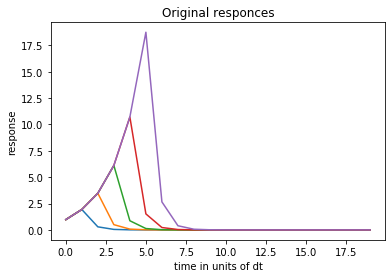

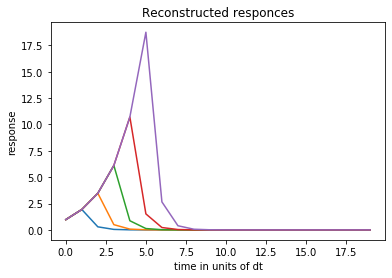

In [27]:
plt.title("Original responces")
plt.plot(orig_responces.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

plt.title("Reconstructed responces")
plt.plot(reconstructed_responces.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()